motifs marked.


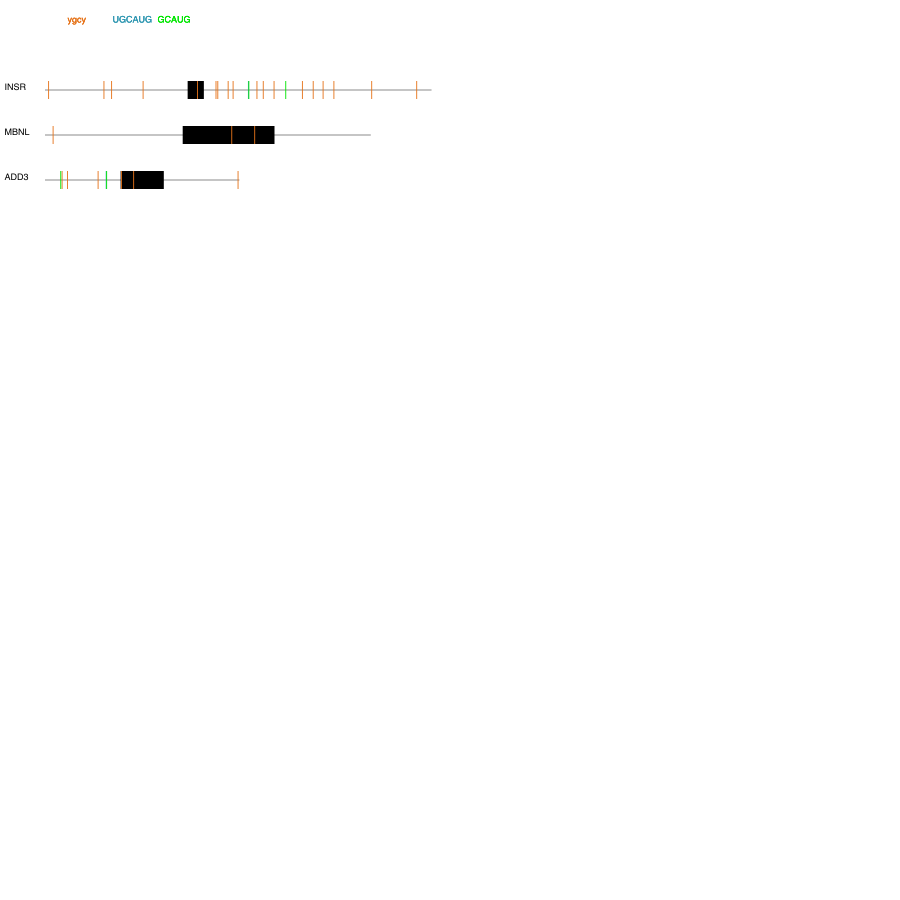

In [47]:
#!/usr/bin/env python

'''onwuzu-motif-mark.py takes a fasta file of uppercase exon and lower case intron bases
and creates a vector-based image of the gene and the motifs of interest'''

#Usage:
#    onwuzu-motif-mark.py -f [absolute path to fasta file] -m [absolute path to motif file] -c [number of motif of interest]
#    onwuzu-motif-mark.py --fasta_file --mtf_file --motif_count


# import argparse

# def get_arguments():
#     parser = argparse.ArgumentParser(description="motif mark program")
#     parser.add_argument("-f", "--fasta_file", help="absolute path to fasta file", required=True, type=str)
#     parser.add_argument("-m", "--motif_file", help="absolute path to motif file", required=True, type=str)
#     return parser.parse_args()

# args = get_arguments()


import re
import cairo
import math
from IPython.display import SVG, display


#mtf_count = len(open(args.motif_file).readlines())

#if mtf_count > 5:
    #raise NameError('Error: motif_count must be less than 6')
          

##convert fasta from multiple sequence lines to single line
#with open(args.fasta_file, "r") as fh1, open(args.fasta_file+'_nonewline_output.fa', 'w') as outh:
with open('sequence.fasta.txt', "r") as fh1, open('seq_nonewline_output.fa', 'w') as outh:
    first_line = True   
    for line in fh1:
        if first_line and line.startswith('>'):
            outh.write(line)       
            first_line = False     
        elif not first_line and line.startswith('>'):        
            outh.write("\n")               
            outh.write(line)
        else:
            outh.write(line.strip())  


motif_dict = {}


iupac_dict = {"B":"[CcGgTtUu]", 
              "D":"[AaGgTtUu]", 
              "H":"[AaCcTtUu]", 
              "K":"[GgTtUu]", 
              "M":"[AaCc]",
              "R":"[AaGg]", 
              "S":"[CcGg]", 
              "V":"[AaCcGg]", 
              "W":"[AaTtUu]", 
              "Y":"[CcTtUu]", 
              "N":"[AaTtCcGgUu]", 
              "A":"[Aa]", 
              "C":"[Cc]", 
              "G":"[Gg]", 
              "T":"[TtUu]", 
              "U":"[TtUu]"}
            
            
            
##convert motif file to motif dict w iupac changes
#with open(args.motif_file, 'r') as mtf_file:    
with open('motifs.txt') as mtf_file:
    for mtf in mtf_file:
        mtf = mtf.strip("\n")
        mtf_upper = mtf.upper()
        mtf_str = list(mtf_upper)
        for i in range(0, len(mtf_str)):
            mtf_str[i] = iupac_dict.get(mtf_str[i])
            iupac_mtf = "".join(mtf_str)
            motif_dict[mtf] = iupac_mtf
            

    
##parse fasta file and convert exon position, seq length and motifs to vector-based image 
surface = cairo.SVGSurface('motif_marked.svg', 900, 900)
context = cairo.Context(surface)
context.scale(450, 450)
context.set_line_width(0.001)


gene_space_count = 0  


mt_color_list = [[0.9, 0.45, 0.1],  
                 [0.2, 0.6, 0.7],
                 [0.0, 0.9, 0.0],
                 [0.3, 0.7, 0.2],
                 [0.8, 0.2, 0.7]]


#with open(args.fasta_file+'_nonewline_output.fa', 'r') as infile:      
with open('seq_nonewline_output.fa', 'r') as infile:
    while True:
        header = infile.readline()
        seq_line = infile.readline()
        
        if header == "":
            break
        
        
        ##extract gene name and seq len 
        header_split = header.split(' ')
        gene_name = header_split[0].split(">")[1]
        seq_len = len(seq_line)
        
        
        ##search seq_line and extract exon pos, exon len etc
        exon = re.search('[A-Z]+', seq_line)
        exon_pos = exon.span()[0]
        exon_str = exon.group()
        exon_len = len(exon_str)
        
         
        ##show extracted gene name
        gene_space_count += 0.1
        context.set_source_rgb(0,0,0)
        context.move_to(0.01, 0.1+gene_space_count)
        context.set_font_size(0.02)
        context.show_text(gene_name)
        
        
        ##draw intron line using gene len 
        ##and make space for next gene draw
        context.move_to(0.1, 0.1+gene_space_count)
        context.line_to(0.1+seq_len/1000, 0.1+gene_space_count)
        context.stroke()

        
        ##drawing exon
        ##draw exon rectangle based on exon pos on gene and exon len
        ##               (x0, x1, y0, y1) => (x, y, length and width)
        context.rectangle(0.1+exon_pos/1000, 0.08+gene_space_count, exon_len/1000, .04) 
        context.fill()
        context.stroke()

        
        ##drawing motif
        ##open motif file and draw motif line using motif position
        col_count = 0
        lgnd_space = 0        
        for mtf_key in motif_dict.keys():       
            m = re.finditer(motif_dict[mtf_key], seq_line)
                
            context.set_source_rgb(*mt_color_list[col_count])
            col_count += 1
            
            lgnd_space += 0.1
            context.move_to(0.05+lgnd_space, 0.05)
            context.set_font_size(0.02)
            context.show_text(mtf_key)
            
             
            for match in m:
                context.rectangle(0.1+match.start()/1000, 0.08+gene_space_count, 0.002, .04) 
                context.fill()
                context.stroke()
                   
            

print("motifs marked.")
surface.write_to_png ("motif_marked.png")
SVG('motif_marked.svg')


